In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
full_data = pd.read_csv('F:/Muthu_2023/Personal/NextStep/MLProjects/Analytics/Datasets/BigBasket/BB_Categorised.csv')
full_data.rename(columns={'Order': 'OrderID', 'Description': 'ProductID', 'Created On': 'OrderDate', 'Member': "CustID"}, inplace=True)
df = full_data[['OrderID', 'ProductID', 'Category', 'Sub Category', 'OrderDate', 'CustID']]
df.head()

,OrderID,ProductID,Category,Sub Category,OrderDate,CustID
0,6468572,Other Sauces,"Oil, Masala and Sauces",Sauces,22-09-2014,M09736
1,6468572,Cashews,Food,Nuts,22-09-2014,M09736
2,6468572,Other Dals,"Rice, Dhal and Flour",Dhal,22-09-2014,M09736
3,6468572,Namkeen,Snacks and Biscuits,Snacks,22-09-2014,M09736
4,6468572,Sugar,"Oil, Masala and Sauces",Masala,22-09-2014,M09736


In [3]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'], dayfirst=True)
df['OrderMonth'] = df['OrderDate'].dt.month
df['OrderDay'] = df['OrderDate'].dt.dayofweek

In [ ]:
df

# LRFMP Analysis

In [36]:
cust_df = pd.DataFrame()

# Length of membership
cust_df['FirstOrder'] = df[['OrderDate', 'CustID']].groupby(by='CustID').min()
cust_df['LastOrder'] = df[['OrderDate', 'CustID']].groupby(by='CustID').max()
cust_df['Length'] = cust_df['LastOrder'] - cust_df['FirstOrder']
cust_df['Length'] = cust_df['Length'].dt.days

# Recent Transaction
LastTxDate = df['OrderDate'].max()
cust_df['Recency'] = LastTxDate - cust_df['LastOrder']
cust_df['Recency'] = cust_df['Recency'].dt.days

# Frequency of Purchase
cust_df['Freq'] = df[['OrderID', 'CustID']].drop_duplicates().groupby(by='CustID').count()

# No of Quantites Purchased
cust_df['Monetary'] = df[['OrderID', 'CustID']].groupby(by='CustID').count()

# The average interval between days which transaction(s) occurred
tempdf = df[['CustID', 'OrderDate']].drop_duplicates().sort_values(by=['CustID', 'OrderDate'])
tempdf['diff'] = tempdf.groupby('CustID').diff(1)
cust_df['Periodicity'] = tempdf[['CustID', 'diff']].groupby('CustID').mean()
cust_df['Periodicity'] = cust_df['Periodicity'].dt.days

# No of Unique Products Purchased
tempdf = df[['CustID', 'ProductID']]
tempdf = tempdf.drop_duplicates()
cust_df['UniqueProd'] = tempdf.groupby('CustID').count()
cust_df.reset_index(inplace=True)
cust_df.drop(['FirstOrder', 'LastOrder'], axis=1, inplace=True)

In [40]:
cust_df_cat.iloc[:,1:]

,Recency,Freq,Monetary,Periodicity,UniqueProd
0,5,132,493,7,69
1,7,55,638,13,62
2,1,105,463,6,63
3,5,62,626,8,58
4,87,39,556,17,55
...,...,...,...,...,...
101,1,79,412,9,50
102,0,66,483,10,60
103,3,73,402,9,52
104,1,78,594,11,26


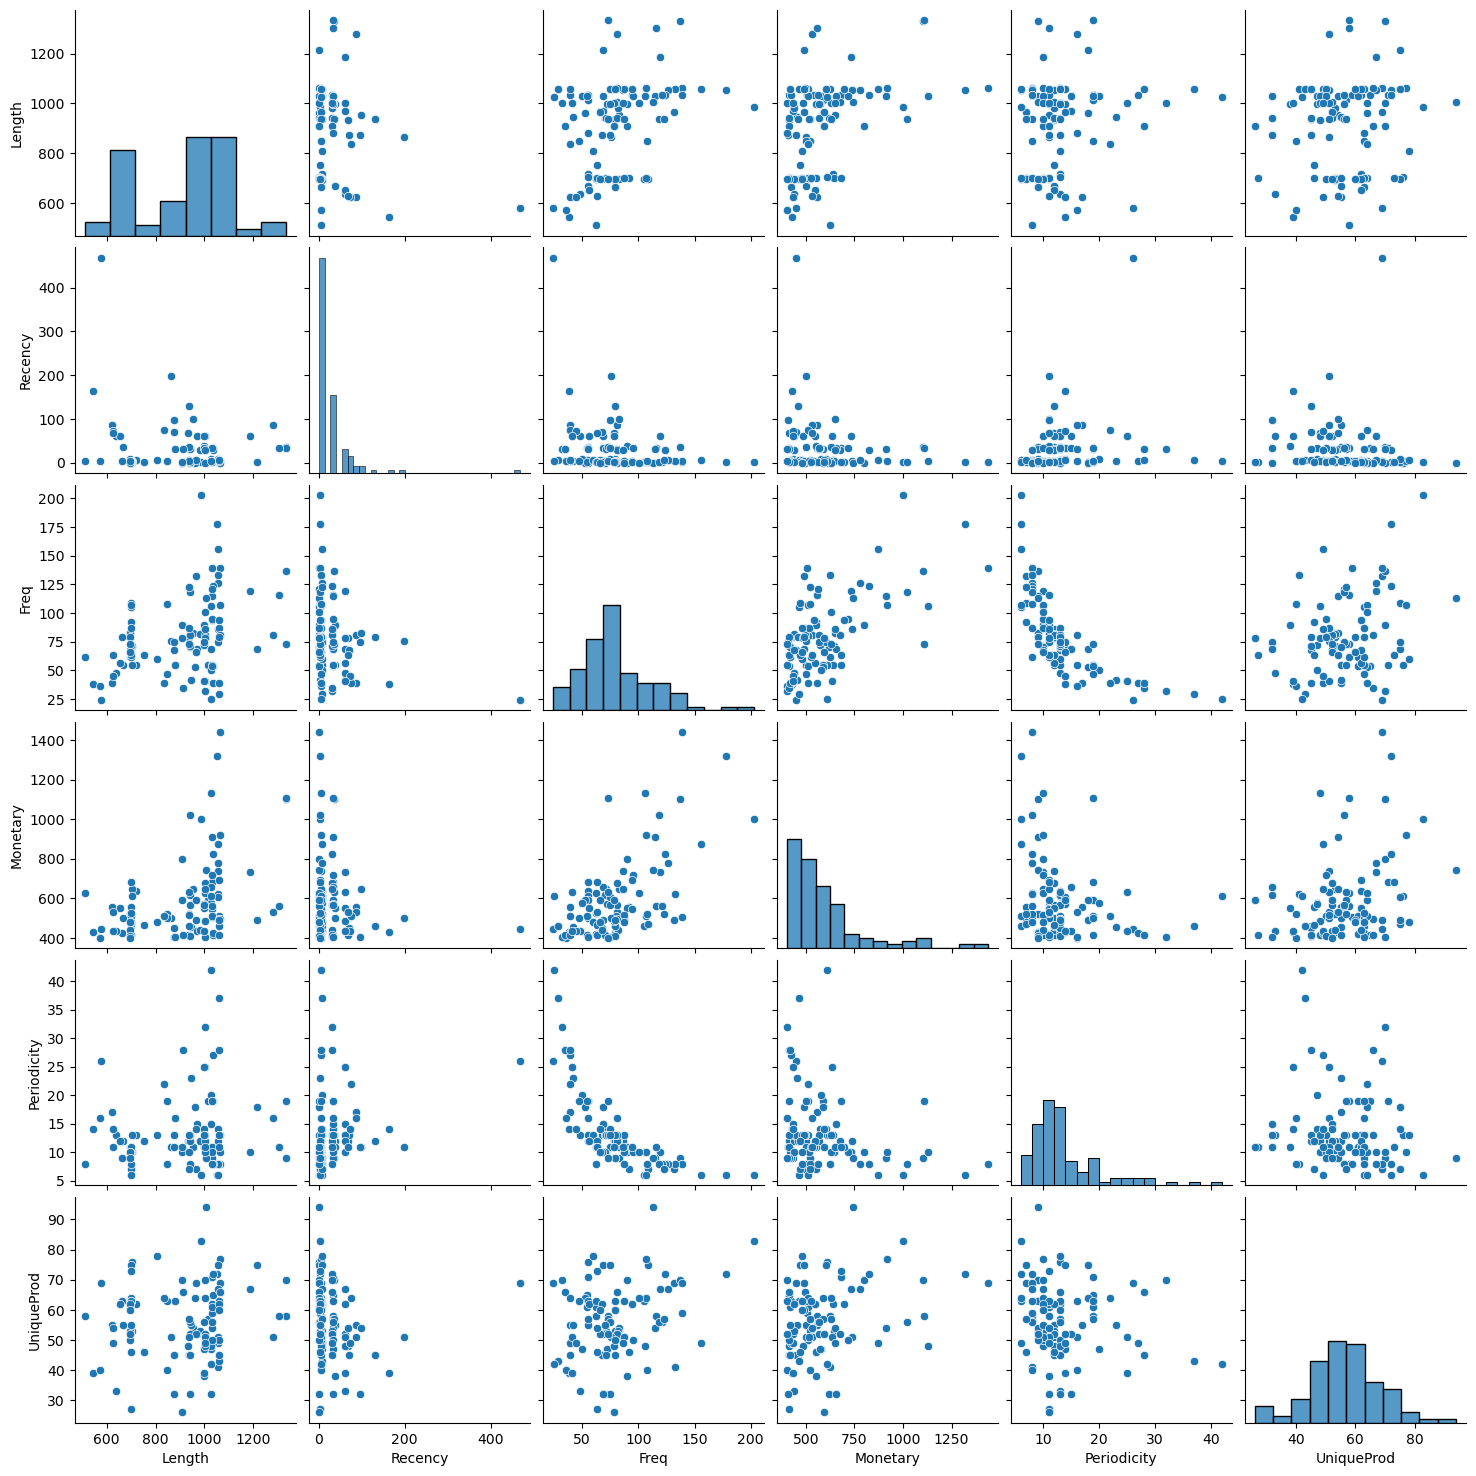

In [6]:
sns.pairplot(cust_df.iloc[:,1:])

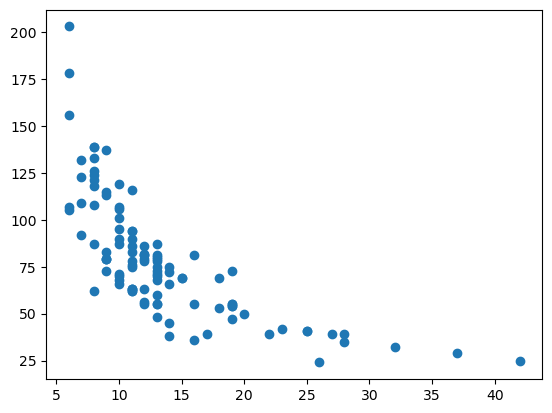

In [7]:
plt.scatter(cust_df.iloc[:,5], cust_df.iloc[:,3])

In [8]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

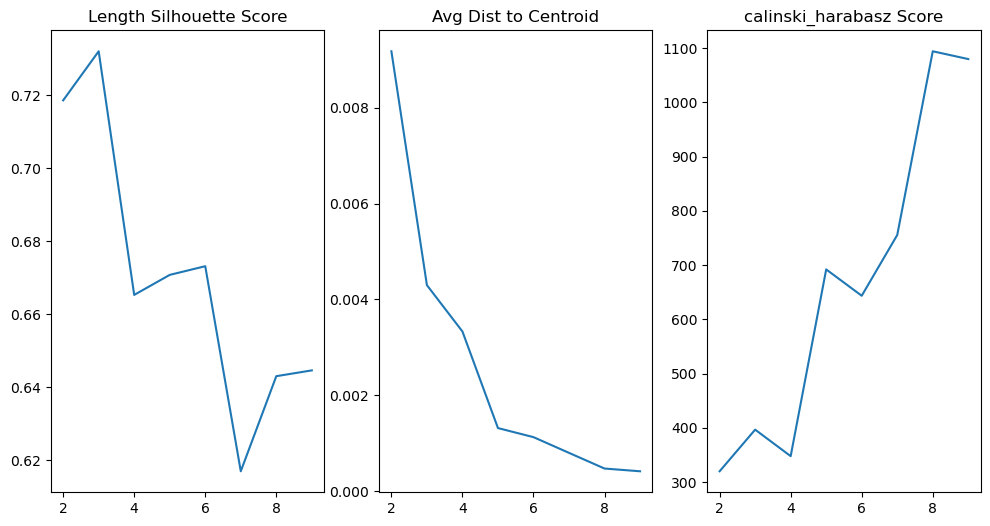

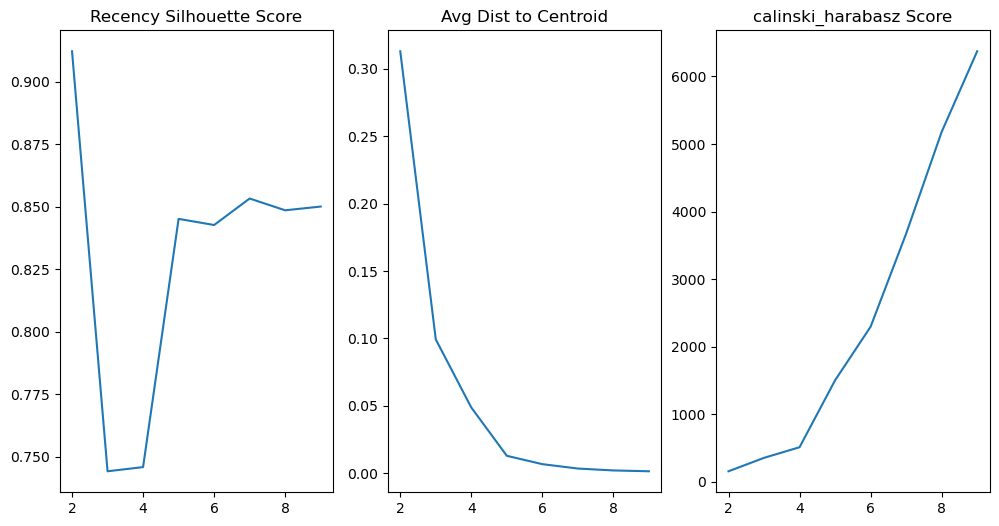

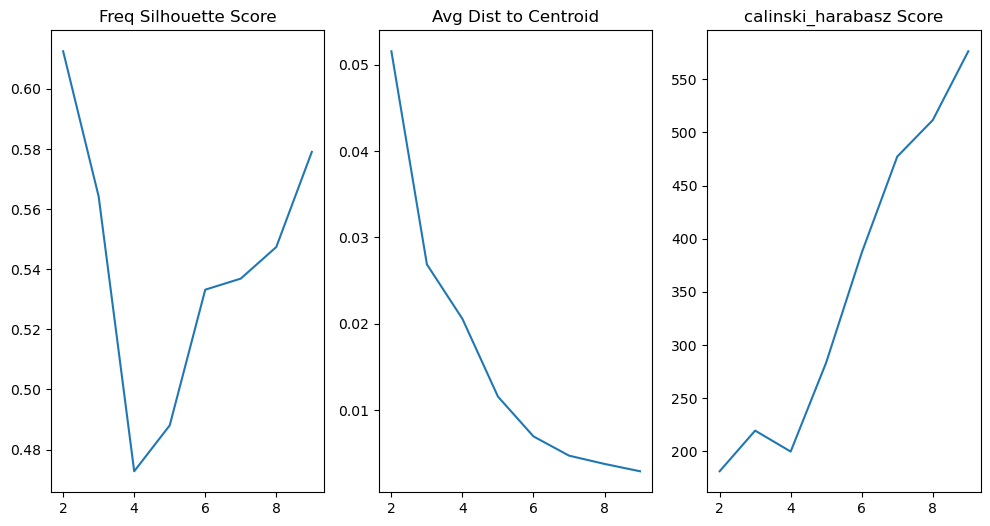

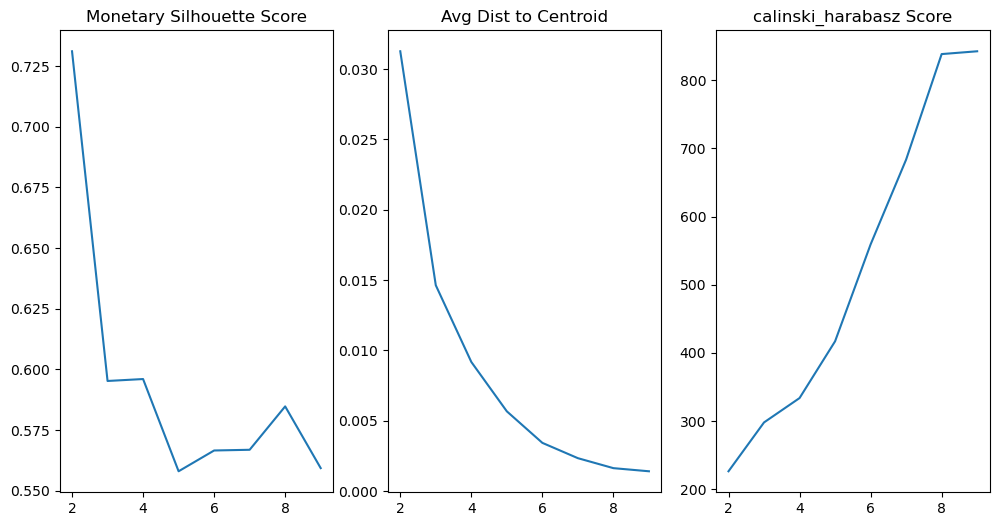

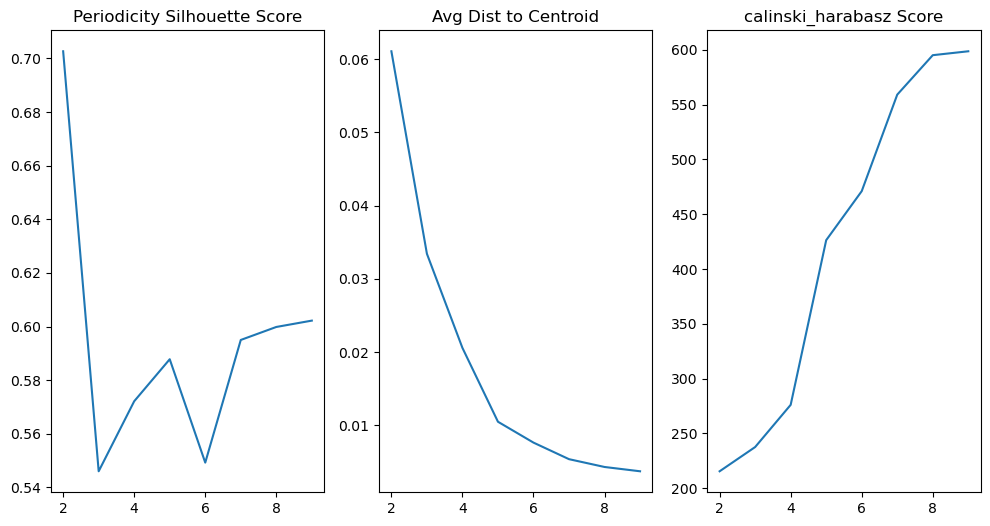

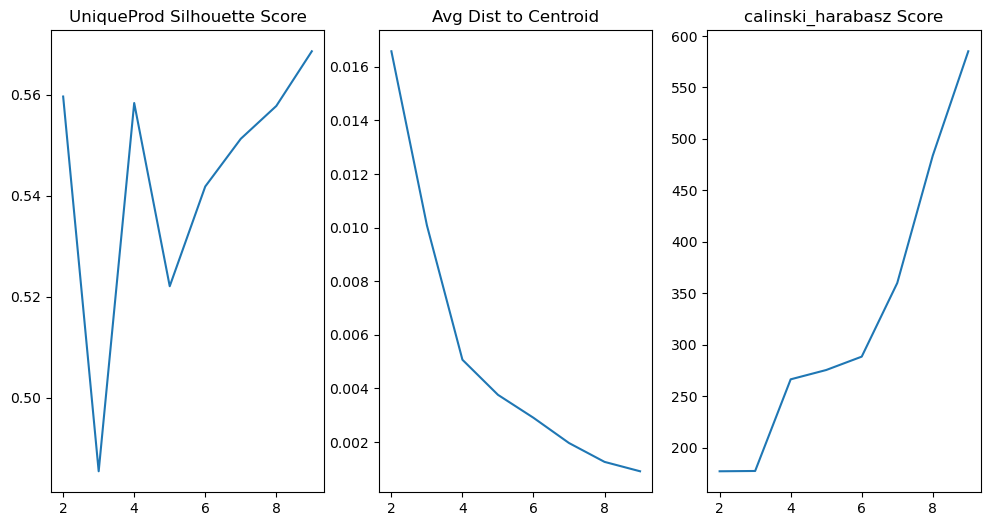

In [9]:
models = []
col_list = cust_df.columns
for i in range(6):
    m = i+1
    n = m+1
    x = np.array(cust_df.iloc[:,m:n])
    if m == n+1:
        x = x.reshape(-1,1)
        xNorm = preprocessing.normalize(x, axis=0)
    else:
        xNorm = preprocessing.normalize(x, axis=0)
    scores = []
    sse = {}
    c_score = []
    for k in range(2,10):
        kmean = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(xNorm)
        score = silhouette_score(xNorm, kmean.labels_, metric = 'euclidean')
        models.append([col_list[i+1], kmean, score])
        scores.append(score)
        sse[k] = kmean.inertia_
        c_score.append( calinski_harabasz_score(xNorm, kmean.labels_))
    plt.figure(figsize=(12,6))
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(2, len(scores)+2), scores)
    plt.title(col_list[i+1] + ' Silhouette Score')
    plt.subplot(1, 3, 2)
    plt.plot(sse.keys(), sse.values())
    plt.title('Avg Dist to Centroid')
    plt.subplot(1, 3, 3)
    plt.plot(np.arange(2, len(c_score)+2), c_score)
    plt.title('calinski_harabasz Score')

In [ ]:
cluster = [[3,4,5],[4],[3,4,5,6],[2,3,4],[3,4,5]]
for i in range(len(cluster)):
    for j in cluster[i]:
        plt.figure(figsize=(12,6))
        k = models[i*8+j-2][1]
        plt.scatter(np.arange(len(cust_df.iloc[:,i+1])), cust_df.iloc[:,i+1],  c=k.labels_, cmap='plasma')
        plt.title(col_list[i+1] + ' ' + str(k.n_clusters))

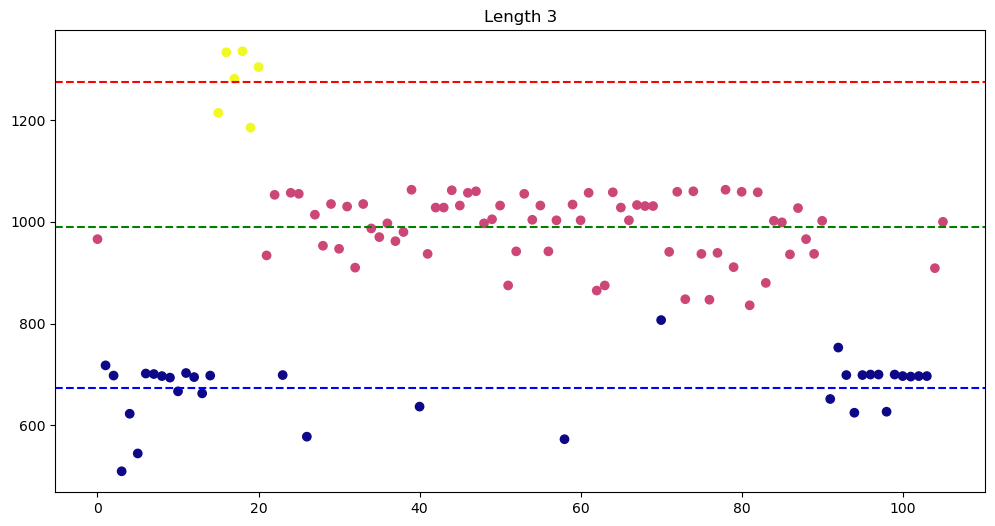

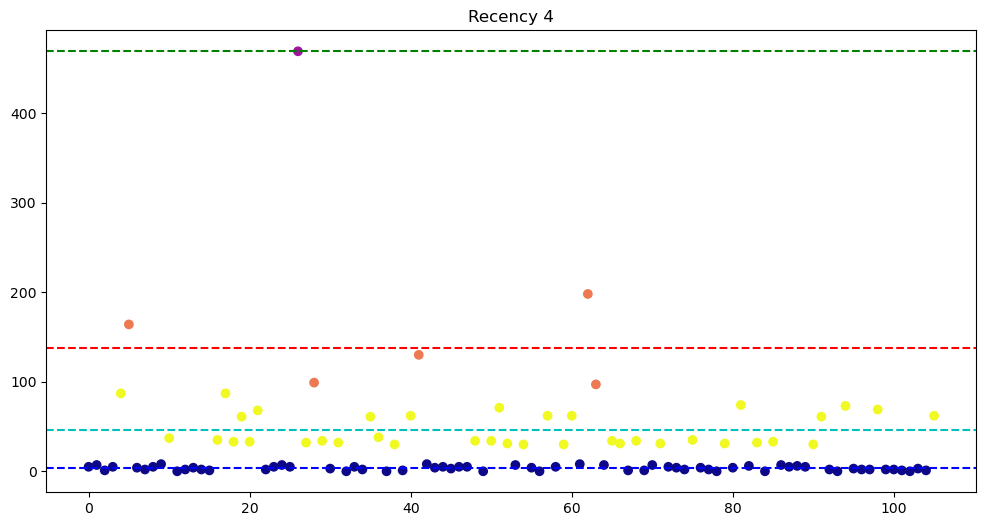

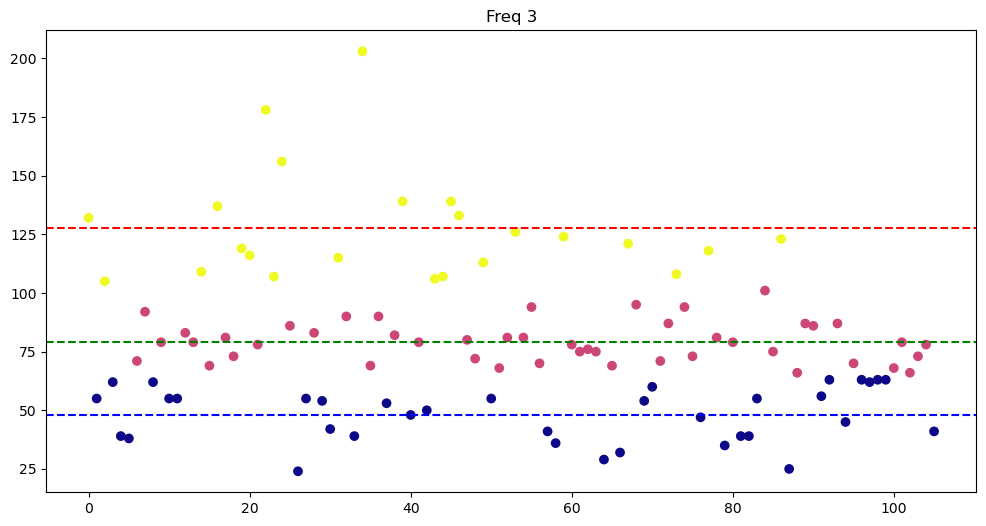

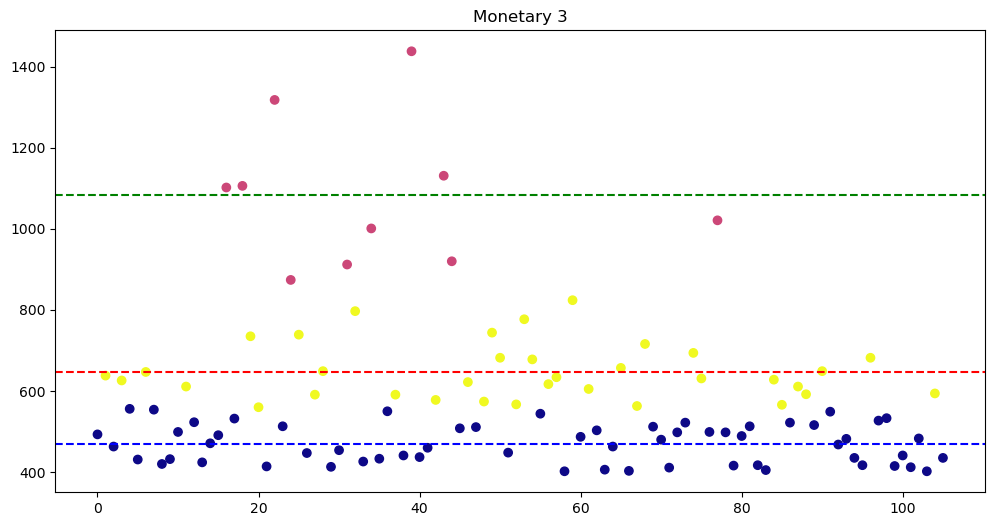

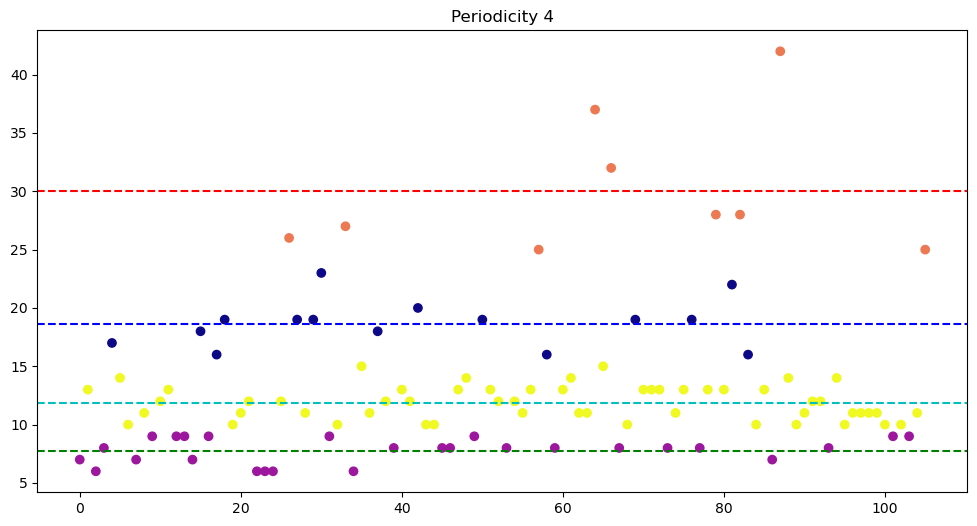

In [127]:
clusters_sel = [3, 4, 3, 3, 4]
for i in range(len(clusters_sel)):    
    plt.figure(figsize=(12,6))    
    k = models[i*8 + clusters_sel[i] - 2][1]
    data = cust_df.iloc[:,i+1]
    plt.scatter(np.arange(len(data)), data,  c=k.labels_, cmap='plasma')
    for j in range(k.n_clusters):
        if j == 0:
            palette = 'b'
        elif j == 1:
            palette = 'g'
        elif j == 2:
            palette = 'r'
        else:
            palette = 'c'
        plt.axhline(y = data[k.labels_ == j].mean(), color = palette, linestyle = 'dashed') 
    #plt.axhline(y = data.mean(), color = 'b', linestyle = '-') 
    plt.title(col_list[i+1] + ' ' + str(k.n_clusters))

In [50]:
clusters_sel = [3, 4, 3, 3, 4]
for i in range(len(clusters_sel)):
    k = models[i*8 + clusters_sel[i] - 2][1]
    cust_df[col_list[i+1] + '_cat'] = k.labels_
    print(col_list[i+1] + ' ' + str(k.n_clusters))

Length 3
Recency 4
Freq 3
Monetary 3
Periodicity 4


In [38]:
cust_df_cat = pd.concat([cust_df.iloc[:,0], cust_df.iloc[:,-5:]], axis=1)

In [52]:
cust_df_cat = cust_df[['CustID', 'Recency_cat', 'Freq_cat','Monetary_cat']]

In [42]:
m, n = 1, -2
cust_df_cat.iloc[:, m:n].drop_duplicates()

,Recency,Freq,Monetary
0,5,132,493
1,7,55,638
2,1,105,463
3,5,62,626
4,87,39,556
...,...,...,...
101,1,79,412
102,0,66,483
103,3,73,402
104,1,78,594


In [53]:
#Categorised
x = np.array(cust_df_cat.iloc[:, 1:])
xNorm = preprocessing.normalize(x, axis=0)
scores_final = []
sse_final = {}
c_score_final = []
model_final = []
Meancluster_cat = []
for k in range(2,10):
    kmean = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(xNorm)
    score_final = silhouette_score(xNorm, kmean.labels_, metric = 'euclidean')
    model_final.append([col_list[i+1], kmean, score])
    scores_final.append(score_final)
    sse_final[k] = kmean.inertia_
    c_score_final.append(calinski_harabasz_score(xNorm, kmean.labels_))
    cust_df_cat['clust_' + str(k)] = kmean.labels_

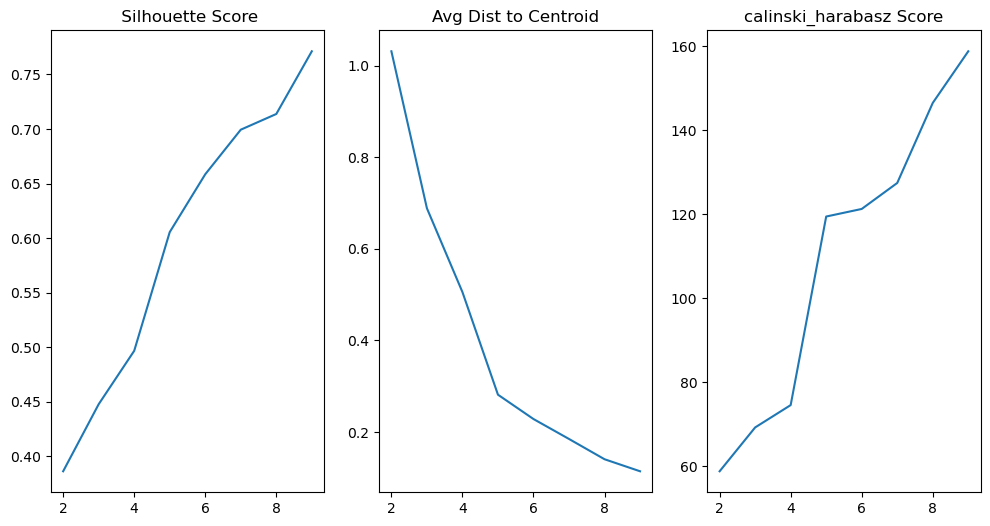

In [54]:
plot_graphs(scores_final, col_list, sse_final, c_score_final)

In [55]:
cust_df_cat

,CustID,Recency_cat,Freq_cat,Monetary_cat,clust_2,clust_3,clust_4,clust_5,clust_6,clust_7,clust_8,clust_9
0,M04158,0,2,0,0,0,3,3,3,3,4,4
1,M08075,0,0,2,1,1,1,1,1,1,7,7
2,M09303,0,2,0,0,0,3,3,3,3,4,4
3,M09736,0,0,2,1,1,1,1,1,1,7,7
4,M12050,3,0,0,0,2,2,2,2,6,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
101,M90375,0,1,0,0,0,0,0,5,5,5,5
102,M91098,0,1,0,0,0,0,0,5,5,5,5
103,M96365,0,1,0,0,0,0,0,5,5,5,5
104,M99030,0,1,2,1,1,1,1,1,1,1,1


In [56]:
test_cust_df = pd.concat([cust_df_cat.iloc[:, 1:4], cust_df_cat['clust_5']], axis=1)

In [57]:
#test_cust_df.to_csv('test.csv')
test_cust_df

,Recency_cat,Freq_cat,Monetary_cat,clust_5
0,0,2,0,3
1,0,0,2,1
2,0,2,0,3
3,0,0,2,1
4,3,0,0,2
...,...,...,...,...
101,0,1,0,0
102,0,1,0,0
103,0,1,0,0
104,0,1,2,1


In [59]:
n_clust = list(test_cust_df['clust_5'].unique())

In [78]:
ry = []
fy = []
my = []
for i in n_clust:
    temp_df = test_cust_df[test_cust_df['clust_5'] == i]
    ry.append(list(map(lambda x: [x, temp_df['Recency_cat'].value_counts()[x]], list(temp_df['Recency_cat'].unique()))))
    fy.append(list(map(lambda x: [x, temp_df['Freq_cat'].value_counts()[x]], list(temp_df['Freq_cat'].unique()))))
    my.append(list(map(lambda x: [x, temp_df['Monetary_cat'].value_counts()[x]], list(temp_df['Monetary_cat'].unique()))))

In [79]:
ry, fy, my

([[[0, 18]],
  [[0, 16]],
  [[3, 20], [2, 4]],
  [[0, 29], [1, 1]],
  [[3, 17], [2, 1]]],
 [[[2, 18]],
  [[0, 7], [1, 9]],
  [[0, 13], [1, 11]],
  [[1, 17], [0, 13]],
  [[2, 5], [1, 10], [0, 3]]],
 [[[0, 7], [1, 7], [2, 4]],
  [[2, 16]],
  [[0, 24]],
  [[0, 30]],
  [[1, 3], [2, 15]]])

In [105]:
ry_df = pd.DataFrame(columns=['R_' + str(i) for i in sorted(list(cust_df_cat['Recency_cat'].unique()))], data=np.zeros((len(n_clust), len(cust_df_cat['Recency_cat'].unique()))))
fy_df = pd.DataFrame(columns=['F_' + str(i) for i in sorted(list(cust_df_cat['Freq_cat'].unique()))], data=np.zeros((len(n_clust), len(cust_df_cat['Freq_cat'].unique()))))
my_df = pd.DataFrame(columns=['M_' + str(i) for i in sorted(list(cust_df_cat['Monetary_cat'].unique()))], data=np.zeros((len(n_clust), len(cust_df_cat['Monetary_cat'].unique()))))

In [113]:
len(ry)

5

In [117]:
def transform(arr, data_frame):
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            ind = arr[i][j][0]
            val = arr[i][j][1]
            data_frame.iloc[i, ind] = val
    return data_frame

In [122]:
ry_df = transform(ry, ry_df)
fy_df = transform(fy, fy_df)
my_df = transform(my, my_df)
combined = pd.concat([ry_df, fy_df, my_df], axis=1)
combined

,R_0,R_1,R_2,R_3,F_0,F_1,F_2,M_0,M_1,M_2
0,18.0,0.0,0.0,0.0,0.0,0.0,18.0,7.0,7.0,4.0
1,16.0,0.0,0.0,0.0,7.0,9.0,0.0,0.0,0.0,16.0
2,0.0,0.0,4.0,20.0,13.0,11.0,0.0,24.0,0.0,0.0
3,29.0,1.0,0.0,0.0,13.0,17.0,0.0,30.0,0.0,0.0
4,0.0,0.0,1.0,17.0,3.0,10.0,5.0,0.0,3.0,15.0


In [ ]:
Meancluster_cat = cust_df_cat.iloc[:,1:].groupby('clust_4').count()
Meancluster_cat

In [ ]:
cust_df_cat.iloc[:,1:]

In [16]:
def plot_graphs(scores, col_list, sse, c_score):
    plt.figure(figsize=(12,6))
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(2, len(scores)+2), scores)
    plt.title(' Silhouette Score')
    plt.subplot(1, 3, 2)
    plt.plot(sse.keys(), sse.values())
    plt.title('Avg Dist to Centroid')
    plt.subplot(1, 3, 3)
    plt.plot(np.arange(2, len(c_score)+2), c_score)
    plt.title('calinski_harabasz Score')

In [ ]:
#Non Categorised
x = np.array(cust_df.iloc[:,1:6])
xNorm = preprocessing.normalize(x, axis=0)
scores_final0 = []
sse_final0 = {}
c_score_final0 = []
model_final0 = []
for k in range(2,10):
    kmean = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(xNorm)
    score_final0 = silhouette_score(xNorm, kmean.labels_, metric = 'euclidean')
    model_final0.append([col_list[i+1], kmean, score])
    scores_final0.append(score_final0)
    sse_final0[k] = kmean.inertia_
    c_score_final0.append(calinski_harabasz_score(xNorm, kmean.labels_))
plot_graphs(scores_final0, col_list, sse_final0, c_score_final0)

In [ ]:
models = np.array(models)
score = np.where(models[:,0]=='Length', models[:,2], -1)
kmean = np.where(models[:,0]=='Length', models[:,1], -1)

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(2, len(score)+2), score)
plt.title('Silhouette Score')
plt.subplot(1, 2, 2)
plt.plot(sse.keys(), sse.values())
plt.title('Avg Dist to Centroid')

In [ ]:
models[2].labels_

In [ ]:
cust_df['Recency'].max()

In [ ]:
sns.boxplot(cust_df.iloc[:,1:])

In [ ]:
cust_df['Cluster'] = models[2].labels_

In [ ]:
cust_df

In [ ]:
cust_cluster = cust_df.iloc[:,1:].groupby('Cluster').mean()

In [ ]:
cust_mean = cust_df.iloc[:,1:-1].mean()

In [ ]:
test['Length']

In [ ]:
cust_profile = cust_cluster.copy()
col = cust_cluster.columns
for i in range(len(col)):
    cust_profile[cust_cluster[col[i]] >= cust_mean[col[i]]] = 1
    cust_profile[cust_cluster[col[i]] < cust_mean[col[i]]] = 0
cust_profile

In [ ]:
cust_cluster

In [ ]:
test

# Apply PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [ ]:
n_comp = n-m
pl = Pipeline([('Scaling', StandardScaler()),
             ('PCA', PCA(n_components=n_comp))])

In [ ]:
pl.fit(cust_df.iloc[:,m:n])

In [ ]:
pca_trans = pl.transform(cust_df.iloc[:,m:n])

In [ ]:
pl['PCA'].components_

In [ ]:
print(pl['PCA'].explained_variance_ratio_)

In [ ]:
plt.scatter(pca_trans[:,0], pca_trans[:,1],  c=models[1].labels_, cmap='plasma')

In [ ]:
fig = plt.figure(figsize=(12,16))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter(pca_trans[:,0], pca_trans[:,1],pca_trans[:,2],  c=models[1].labels_, cmap='plasma')

In [ ]:
fig = plt.figure(figsize=(12,16))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter(xNorm[:,0], xNorm[:,1],xNorm[:,2], cmap='plasma')